In [127]:
%pip install ucimlrepo

In [128]:
## for data
import pandas as pd
import numpy as np
## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
## for statistical tests
import scipy
import statsmodels.formula.api as smf
import statsmodels.api as sm
## for machine learning
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition

import warnings
warnings.filterwarnings('ignore')

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import cross_val_score

from sklearn import metrics
from collections import Counter

In [129]:
# Датасет "Рецидивы дифференцированного рака щитовидной железы"
from ucimlrepo import fetch_ucirepo

differentiated_thyroid_cancer_recurrence = fetch_ucirepo(id=915)
x=differentiated_thyroid_cancer_recurrence.data.features
y=differentiated_thyroid_cancer_recurrence.data.targets

df = pd.merge(
    x,
    y,
    how='inner',
    left_index=True, right_index=True
)
df.head(5)

,Age,Gender,Smoking,Hx Smoking,Hx Radiothreapy,Thyroid Function,Physical Examination,Adenopathy,Pathology,Focality,Risk,T,N,M,Stage,Response,Recurred
0,27,F,No,No,No,Euthyroid,Single nodular goiter-left,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Indeterminate,No
1,34,F,No,Yes,No,Euthyroid,Multinodular goiter,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent,No
2,30,F,No,No,No,Euthyroid,Single nodular goiter-right,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent,No
3,62,F,No,No,No,Euthyroid,Single nodular goiter-right,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent,No
4,62,F,No,No,No,Euthyroid,Multinodular goiter,No,Micropapillary,Multi-Focal,Low,T1a,N0,M0,I,Excellent,No


In [130]:
df = pd.concat([df, df[df["Recurred"]=="Yes"], df[df["Recurred"]=="Yes"]])

In [131]:
df = df.iloc[:-49]
df['Recurred'].value_counts()

,count
Recurred,
No,275
Yes,275


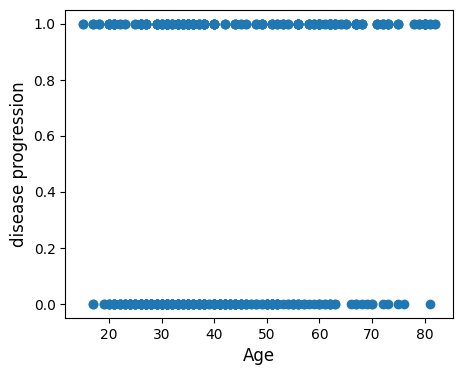

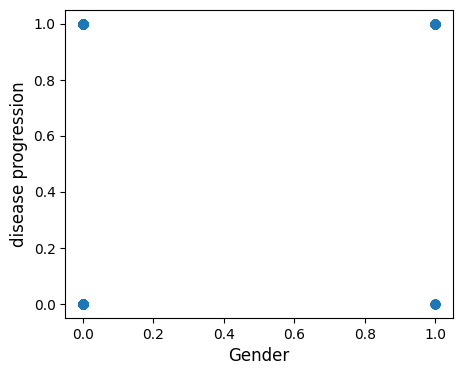

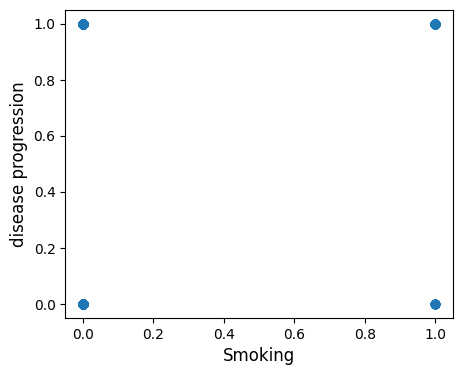

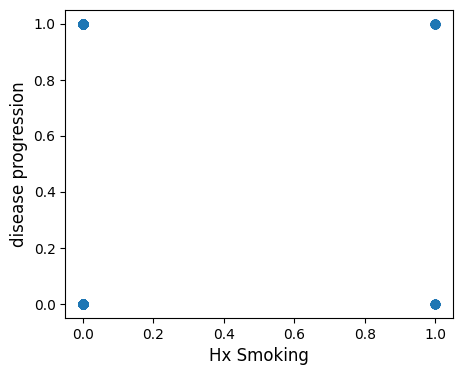

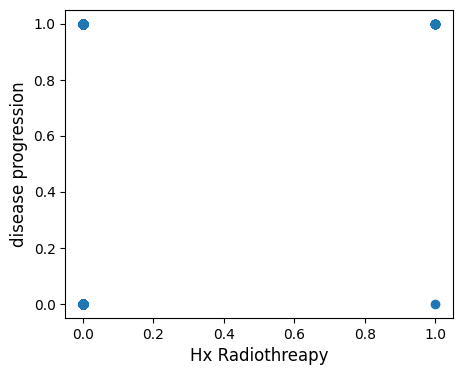

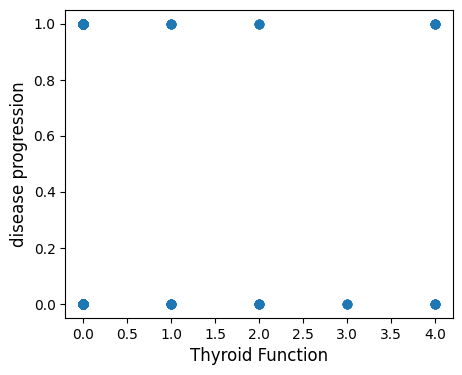

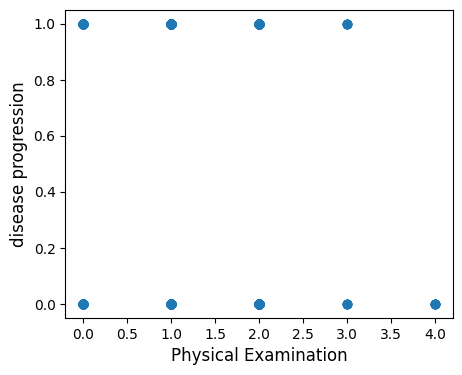

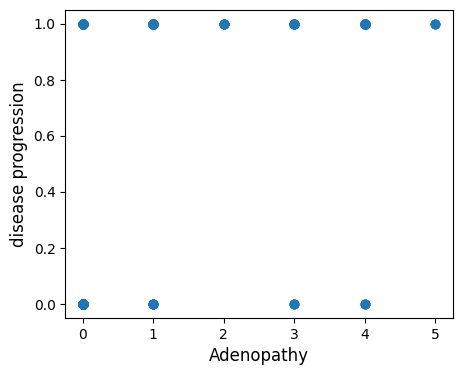

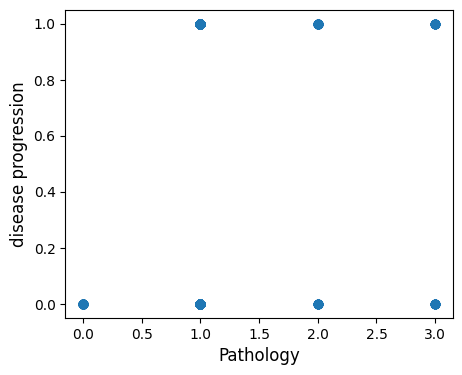

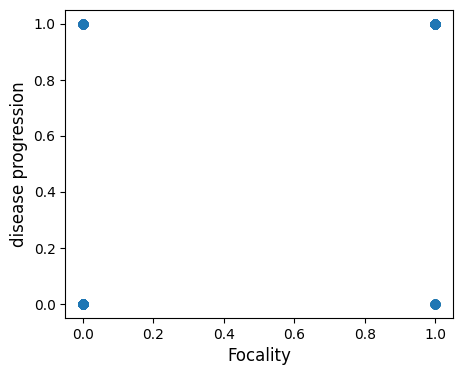

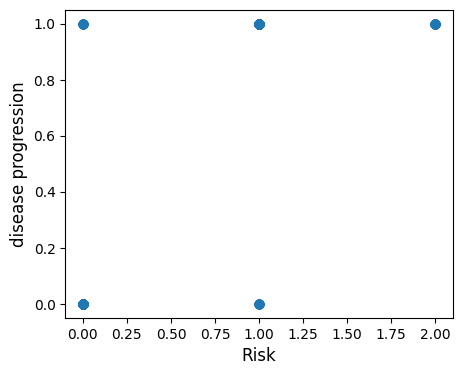

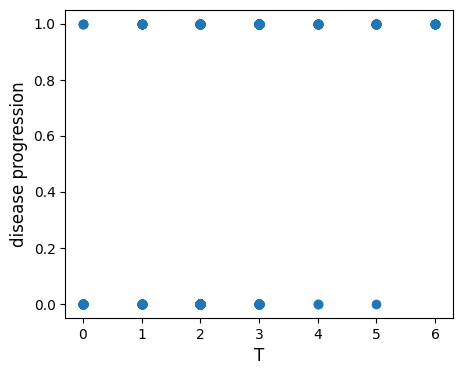

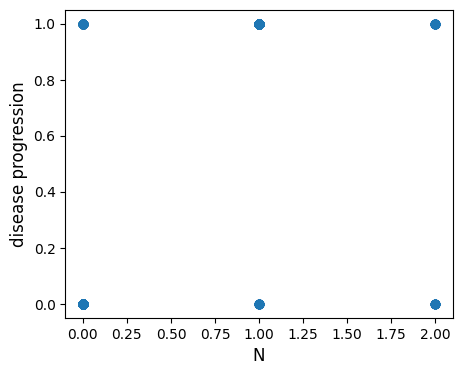

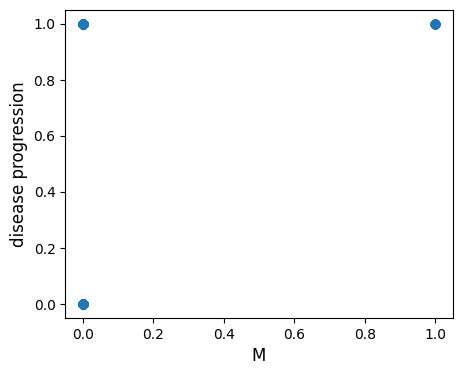

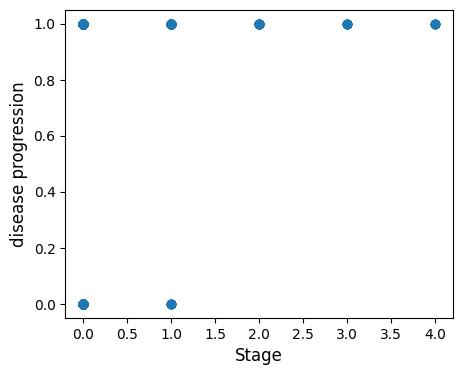

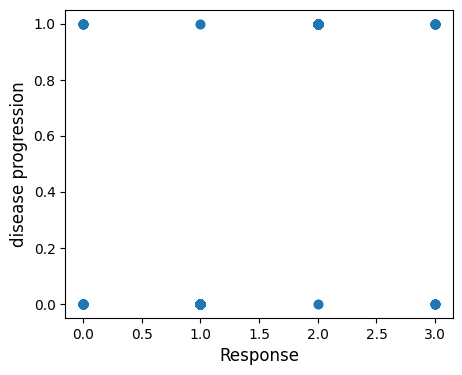

In [151]:
target = "Recurred"
vizual_x = "Age"

for index, feature_name in enumerate(df.drop(target, axis=1).columns):
    plt.figure(figsize=(5, 4))
    plt.scatter(df[feature_name], df[target])
    plt.ylabel('disease progression', size=12)
    plt.xlabel(feature_name, size=12)
    plt.show()

In [133]:
cat_columns = df.select_dtypes(['object']).columns
df[cat_columns] = df[cat_columns].apply ( lambda x: pd.factorize (x)[ 0 ])

In [134]:
df_train, df_test = model_selection.train_test_split(df, test_size=0.2, random_state=47)

In [135]:
X_train = df_train.drop(target,axis=1)
y_train = df_train[target]

X_test = df_test.drop(target,axis=1)
y_test = df_test[target]

In [136]:
# сразу напишем код функции, которая будет вычислять все нужные метрики

def Reg_Models_Evaluation_Metrics (model,X_train,y_train,X_test,y_test,y_pred):
    cv_score = cross_val_score(estimator = model, X = X_train, y = y_train, cv = 10)

    # Calculating Adjusted R-squared
    r2 = model.score(X_test, y_test)
    # Number of observations is the shape along axis 0
    n = X_test.shape[0]
    # Number of features (predictors, p) is the shape along axis 1
    p = X_test.shape[1]
    # Adjusted R-squared formula
    adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
    RMSE = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    R2 = model.score(X_test, y_test)
    CV_R2 = cv_score.mean()

    print(f'RMSE:  {round(RMSE,4)}\n  R2: {round(R2,4)}\n Adjusted R2: {round(adjusted_r2, 4)}\n Cross Validated R2: {round(cv_score.mean(),4)}')
    return R2, adjusted_r2, CV_R2, RMSE

In [137]:
from sklearn.linear_model import LinearRegression

# Create a linear regression model
modelLR = LinearRegression()

# Fit the model to the data
modelLR.fit(X_train, y_train)

# Predict the response for a new data point
y_pr_LR = modelLR.predict(X_test)

_ = Reg_Models_Evaluation_Metrics(modelLR, X_train, y_train, X_test, y_test, y_pr_LR)

RMSE:  0.2817
  R2: 0.6816
 Adjusted R2: 0.6268
 Cross Validated R2: 0.6518


In [138]:
from sklearn.tree import DecisionTreeRegressor

# Create a stepwise regression model
modelDT = DecisionTreeRegressor()

# Fit the model to the data
modelDT.fit(X_train, y_train)

# Predict the response for a new data point
y_dt_pred = modelDT.predict(X_test)

_ = Reg_Models_Evaluation_Metrics(modelDT, X_train, y_train, X_test, y_test, y_dt_pred)

RMSE:  0.1907
  R2: 0.8541
 Adjusted R2: 0.829
 Cross Validated R2: 0.8158


In [139]:
from sklearn.ensemble import RandomForestRegressor

# Create a stepwise regression model
modelRF = RandomForestRegressor(n_estimators=100)

# Fit the model to the data
modelRF.fit(X_train, y_train)

# Predict the response for a new data point
y_rf_pred = modelRF.predict(X_test)

_ = Reg_Models_Evaluation_Metrics(modelRF, X_train, y_train, X_test, y_test, y_rf_pred)

RMSE:  0.1451
  R2: 0.9155
 Adjusted R2: 0.901
 Cross Validated R2: 0.8939


In [140]:
from sklearn.svm import SVR

# Create a support vector regression model
modelSVR = SVR(kernel='linear')

modelSVR.fit(X_train, y_train)

# Predict the response for a new data point
y_rf_pred = modelSVR.predict(X_test)

_ = Reg_Models_Evaluation_Metrics(modelSVR, X_train, y_train, X_test, y_test, y_rf_pred)

RMSE:  0.3143
  R2: 0.6036
 Adjusted R2: 0.5354
 Cross Validated R2: 0.629


In [141]:
from sklearn.svm import SVR

# Create a support vector regression model. Полиномиальное ядро
modelSVR = SVR(kernel='poly')

modelSVR.fit(X_train, y_train)

# Predict the response for a new data point
y_rf_pred = modelSVR.predict(X_test)

_ = Reg_Models_Evaluation_Metrics(modelSVR, X_train, y_train, X_test, y_test, y_rf_pred)

RMSE:  0.4073
  R2: 0.3345
 Adjusted R2: 0.22
 Cross Validated R2: 0.2667


In [142]:
# Create a support vector regression model. Ядро - радиальная базисная функция
modelSVR = SVR(kernel='rbf')

modelSVR.fit(X_train, y_train)

# Predict the response for a new data point
y_rf_pred = modelSVR.predict(X_test)


_ = Reg_Models_Evaluation_Metrics(modelSVR, X_train, y_train, X_test, y_test, y_rf_pred)

RMSE:  0.3147
  R2: 0.6028
 Adjusted R2: 0.5344
 Cross Validated R2: 0.567


In [143]:
from sklearn.linear_model import ElasticNet

# Create an elastic net regression model
modelEN = ElasticNet(alpha=0.1, l1_ratio=0.8)

# Fit the model to the data
modelEN.fit(X_train, y_train)

# Predict the response for a new data point
y_en_pred = modelEN.predict(X_test)

_ = Reg_Models_Evaluation_Metrics(modelEN, X_train, y_train, X_test, y_test, y_en_pred)

RMSE:  0.3308
  R2: 0.561
 Adjusted R2: 0.4855
 Cross Validated R2: 0.549


In [147]:
def Viz_Plot(model):
  plt.scatter(X_train[vizual_x], y_train, color='darkorange',
            label='data')
  plt.plot(X_train[vizual_x], model.predict(X_train), color='cornflowerblue',
          label='prediction')
  plt.legend()
  plt.show()

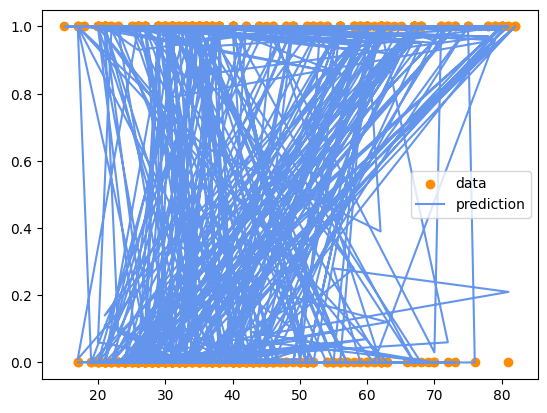

In [152]:
Viz_Plot(modelRF)

In [149]:
_ = Reg_Models_Evaluation_Metrics(modelRF, X_train, y_train, X_test, y_test, y_rf_pred)

RMSE:  0.3147
  R2: 0.9155
 Adjusted R2: 0.901
 Cross Validated R2: 0.8953
